**Author:** *Johannes Peter Knoll*

# Introduction

This Notebook is supposed to demonstrate that the functions implemented in this project work correctly.
If you trust my coding skills you can skip this, as it is unnecessarily thorough and was mainly designed 
to help me check my functions.

In [1]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Parameters and Files

In [2]:
import random
import numpy as np

In [14]:
# import secondary python files
import main
import read_edf
import MAD
import rpeak_detection
import check_data
import plot_helper
import rri_from_rpeak
from side_functions import *

In [5]:
parameters = main.parameters

# ECG Validation

## Straighten the ECG signal:

To improve the recognition of valid ECG regions the signal should be "straightened" first

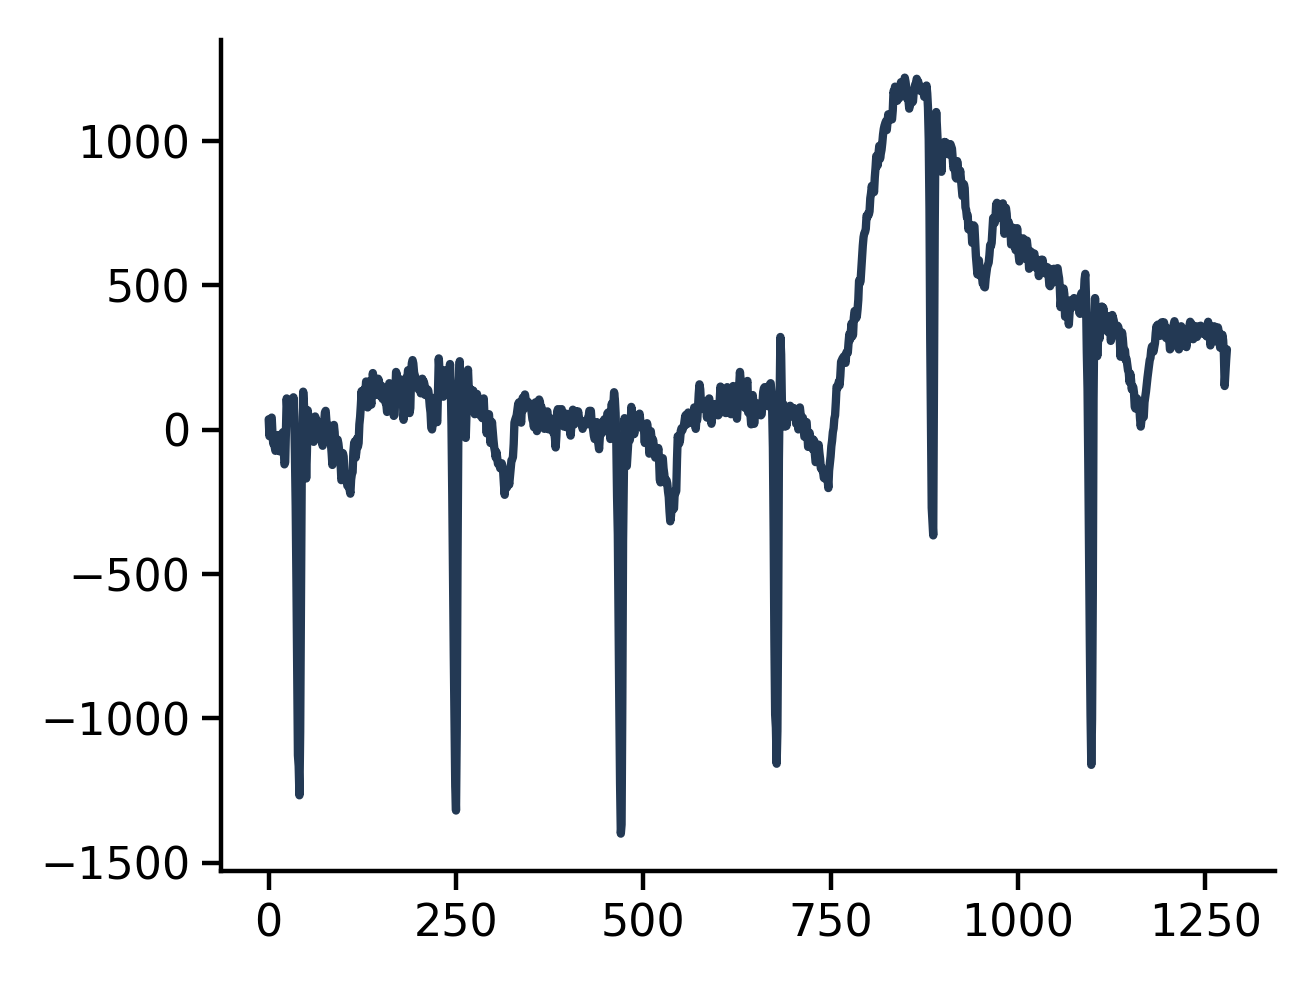

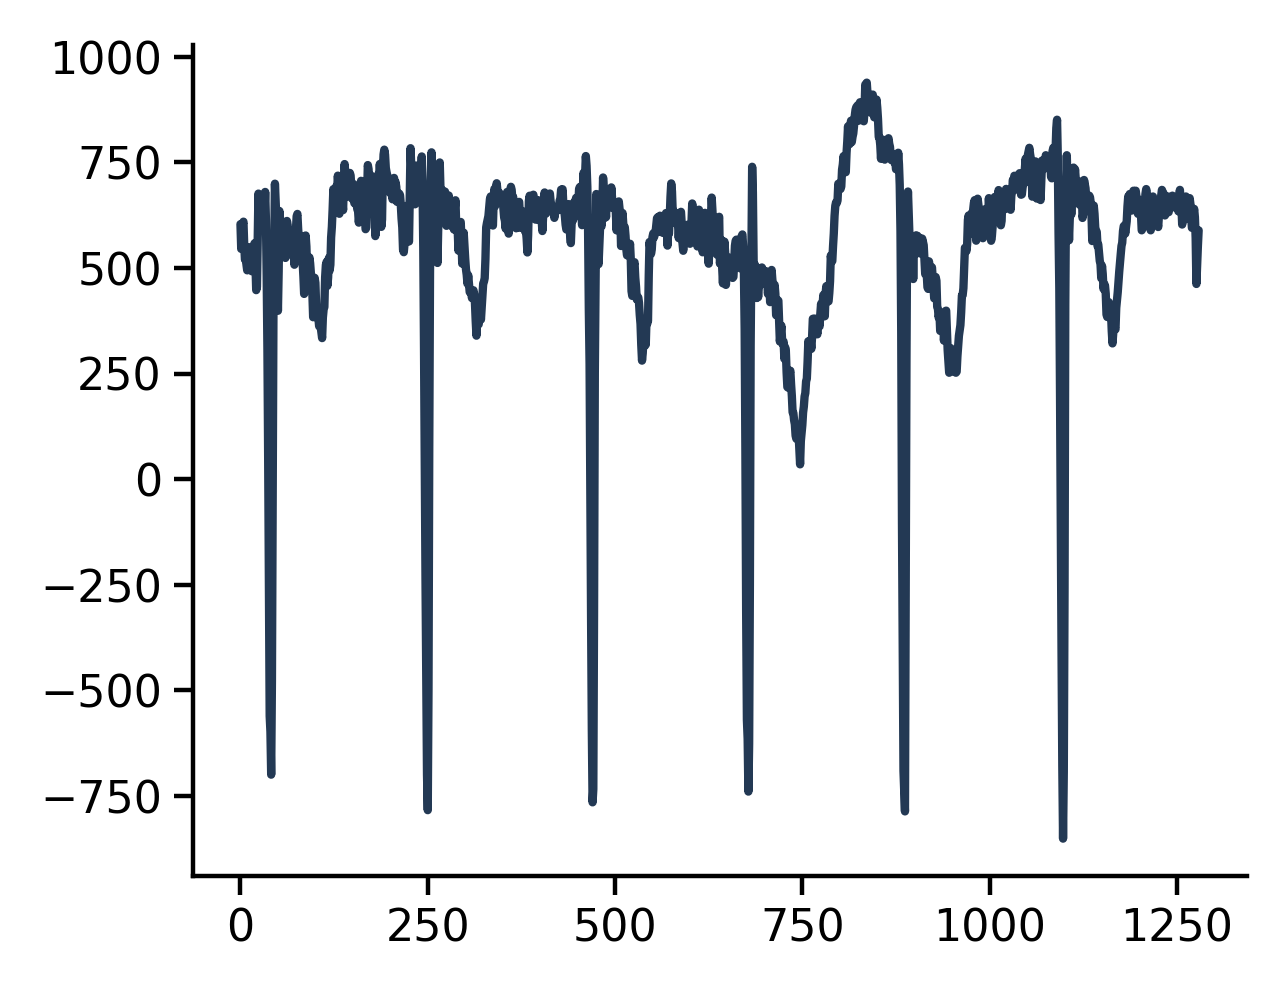

In [15]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"
file_data_path = data_directory + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

lower_border = 1012500
interval_size = 1280
interval = [lower_border, lower_border + interval_size]
ecg_signal = ECG[lower_border:lower_border + interval_size]

plot_helper.simple_plot(ecg_signal)

straightened_ecg = check_data.straighten_ecg(ecg_signal, frequency)

plot_helper.simple_plot(straightened_ecg)

## Evaluate and show valid ECG regions:

Here you can evaluate and plot the valid regions of the ECG data from scratch.

Go ahead and change the file_name and xlim to see different data in different intervals!

(Valid / Total) Regions Ratio: 78.120000 %


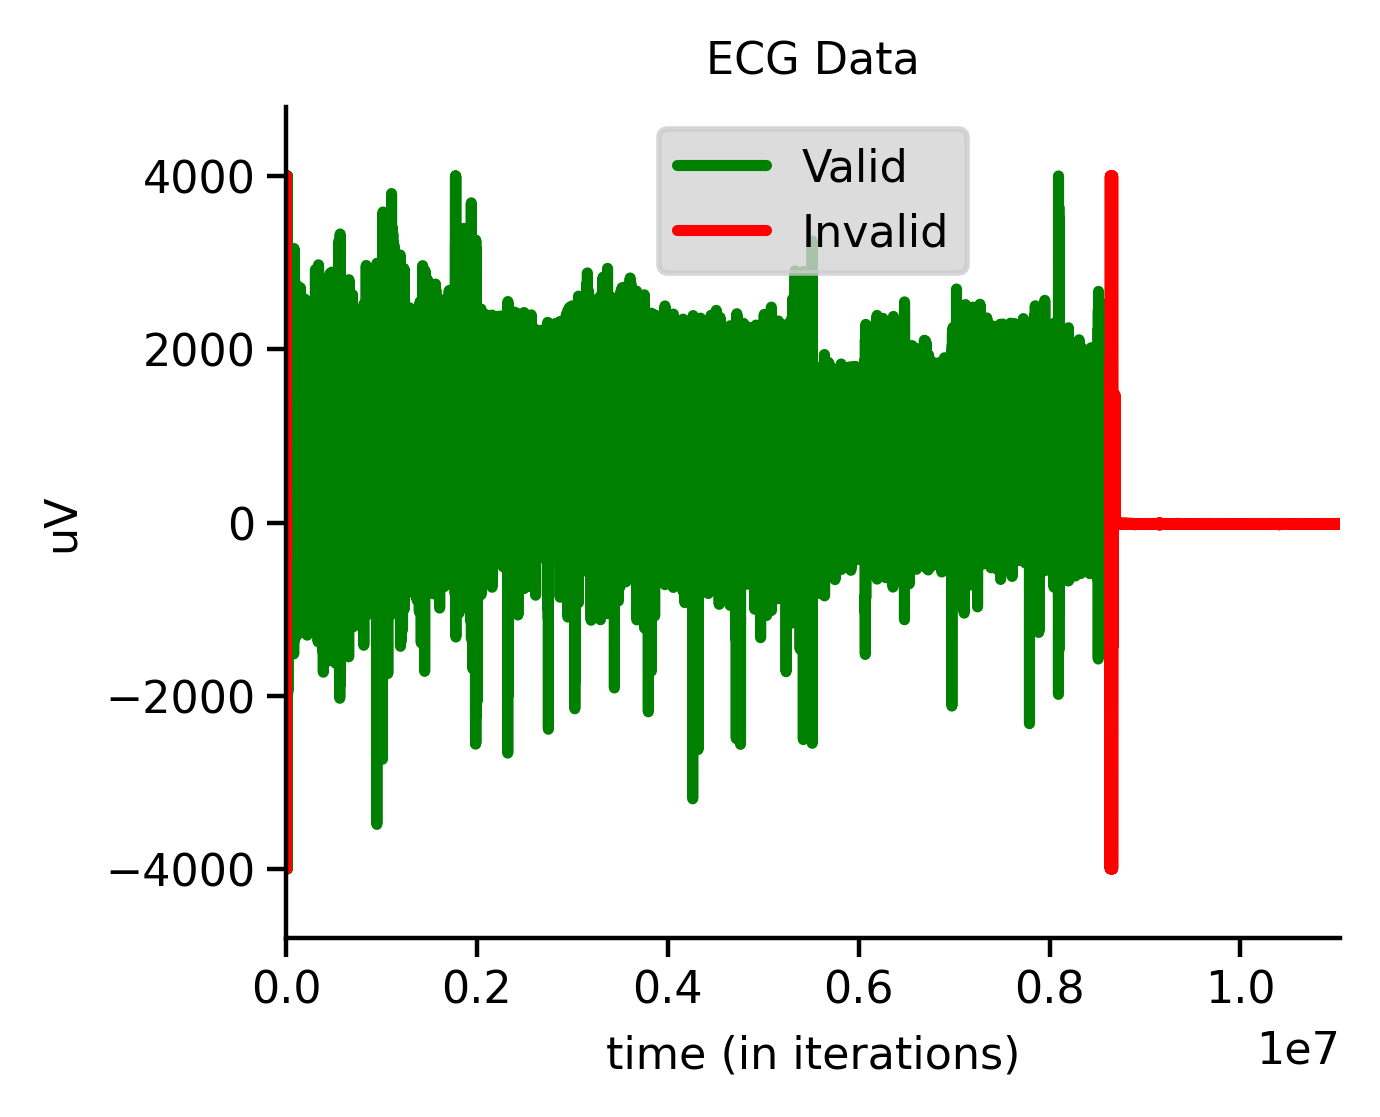

In [16]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL104_SL104_(1).edf"
file_data_path = data_directory + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

results = check_data.check_ecg(
    ECG=ECG, 
    frequency=frequency, 
    check_ecg_time_interval_seconds=5,  
    straighten_ecg_signal=True, 
    check_ecg_overlapping_interval_steps=1, 
    check_ecg_validation_strictness=[0.4, 0.6, 0.8],
    check_ecg_removed_peak_difference_threshold=0.3,
    check_ecg_std_min_threshold=80,
    check_ecg_std_max_threshold=800,
    check_ecg_distance_std_ratio_threshold=5,
    check_ecg_allowed_invalid_region_length_seconds=30,
    check_ecg_min_valid_length_minutes=5,
    )

valid_regions_for_one_val_strictness = results[1] # looks weird I know, but it is the way it is (reason is behind ecg validation comparison)

# calculate the ratio of valid regions to total regions
valid_regions_ratio = check_data.determine_valid_total_ecg_ratio(
    ECG_length = len(ECG), 
    valid_regions = valid_regions_for_one_val_strictness
    )
print("(Valid / Total) Regions Ratio: %f %%" % (round(valid_regions_ratio, 4)*100))

# choose region to plot
total_length = len(ECG)
x_lim = [int(0*total_length), int(1*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = valid_regions_for_one_val_strictness,
    xlim = x_lim
    )

# Calculating R-Peaks

The following code will calculate the r-peaks from scratch for the given file.
Be careful, as you need to choose an interval yourself

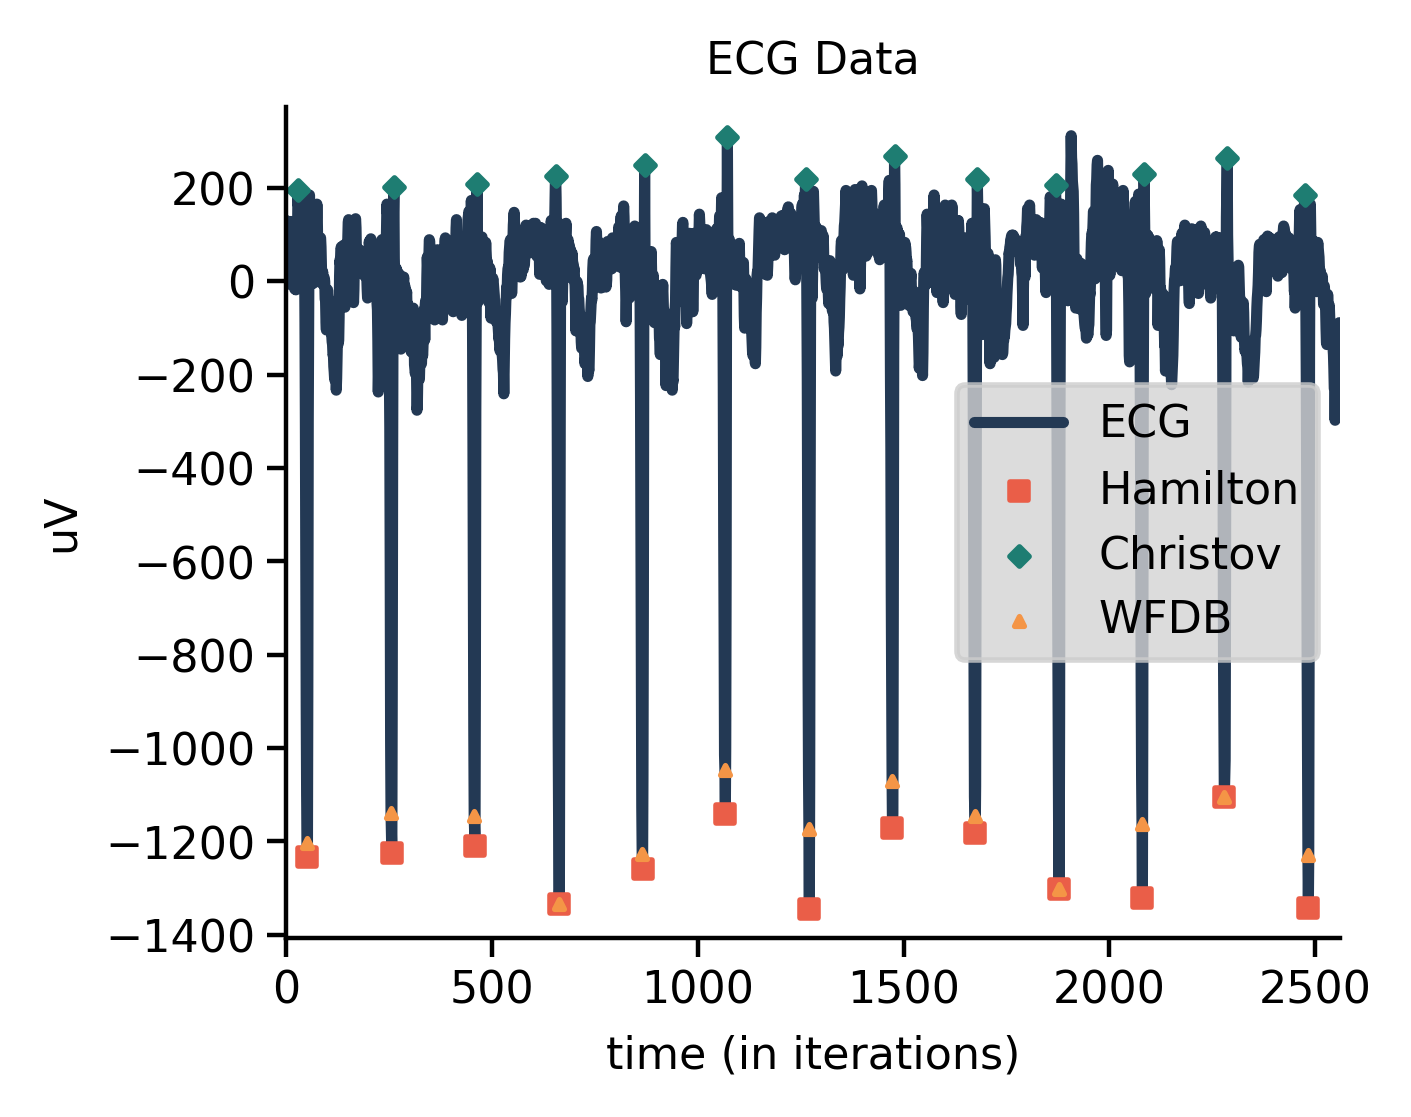

In [17]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"

# choose interval
interval_size = 2560
lower_bound = 1781760
interval = [lower_bound, lower_bound + interval_size]

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = data_directory + file_data_name,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

ecg_signal = ECG[interval[0]:interval[1]]

# calculate r-peaks
rpeaks_hamilton = rpeak_detection.get_rpeaks_hamilton(ecg_signal, frequency, None) # type: ignore
rpeaks_christov = rpeak_detection.get_rpeaks_christov(ecg_signal, frequency, None) # type: ignore
rpeaks_wfdb = rpeak_detection.get_rpeaks_wfdb(ecg_signal, frequency, None) # type: ignore
rpeaks_ecgdet = rpeak_detection.get_rpeaks_ecgdetectors(ecg_signal, frequency, None) # type: ignore

# plot the r-peaks
plot_helper.plot_rpeak_detection(
    ECG = ecg_signal,
    rpeaks = [rpeaks_hamilton,rpeaks_christov,rpeaks_wfdb],
    rpeaks_name = ["Hamilton","Christov","WFDB"],
)

# Calculating RRI Values

In [18]:
some_rpeak_locations = [719978, 720177, 720405, 720616, 720859, 721111, 721331, 721571, 721792, 722018, 722246, 722479, 722698, 722918, 723163, 723395, 723629, 723857, 724085, 724302]
some_rpeak_locations = np.array(some_rpeak_locations)
some_rpeak_locations = some_rpeak_locations - some_rpeak_locations[0]
print(some_rpeak_locations)
print("\n")
print(rri_from_rpeak.calculate_rri_from_peaks(
    rpeaks = some_rpeak_locations, 
    ecg_sampling_frequency = 256, 
    target_sampling_frequency = 0.2, 
    signal_length = 5000))


some_rpeak_locations = [723629, 723857, 724085, 724302, 724302+1000*256, 724302+1000*256+0.7*256, 724302+1000*256+1.4*256]
some_rpeak_locations = np.array(some_rpeak_locations)
some_rpeak_locations = some_rpeak_locations - some_rpeak_locations[0]
print(some_rpeak_locations)
print("\n")
print(rri_from_rpeak.calculate_rri_from_peaks(
    rpeaks = some_rpeak_locations, 
    ecg_sampling_frequency = 256, 
    target_sampling_frequency = 4, 
    signal_length = 50000*6))

[   0  199  427  638  881 1133 1353 1593 1814 2040 2268 2501 2720 2940
 3185 3417 3651 3879 4107 4324]


[0.88515625, 0.896875, 0.9091796875]
[0.000000e+00 2.280000e+02 4.560000e+02 6.730000e+02 2.566730e+05
 2.568522e+05 2.570314e+05]


[0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.84765625, 0.84765625, 0.84765625, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.

# Calculating MAD Values

The calculated MAD Values will be plotted in a random interval. Of course you can change the
interval size or even define the interval yourself. Go ahead and look at a few different intervals
for different files!

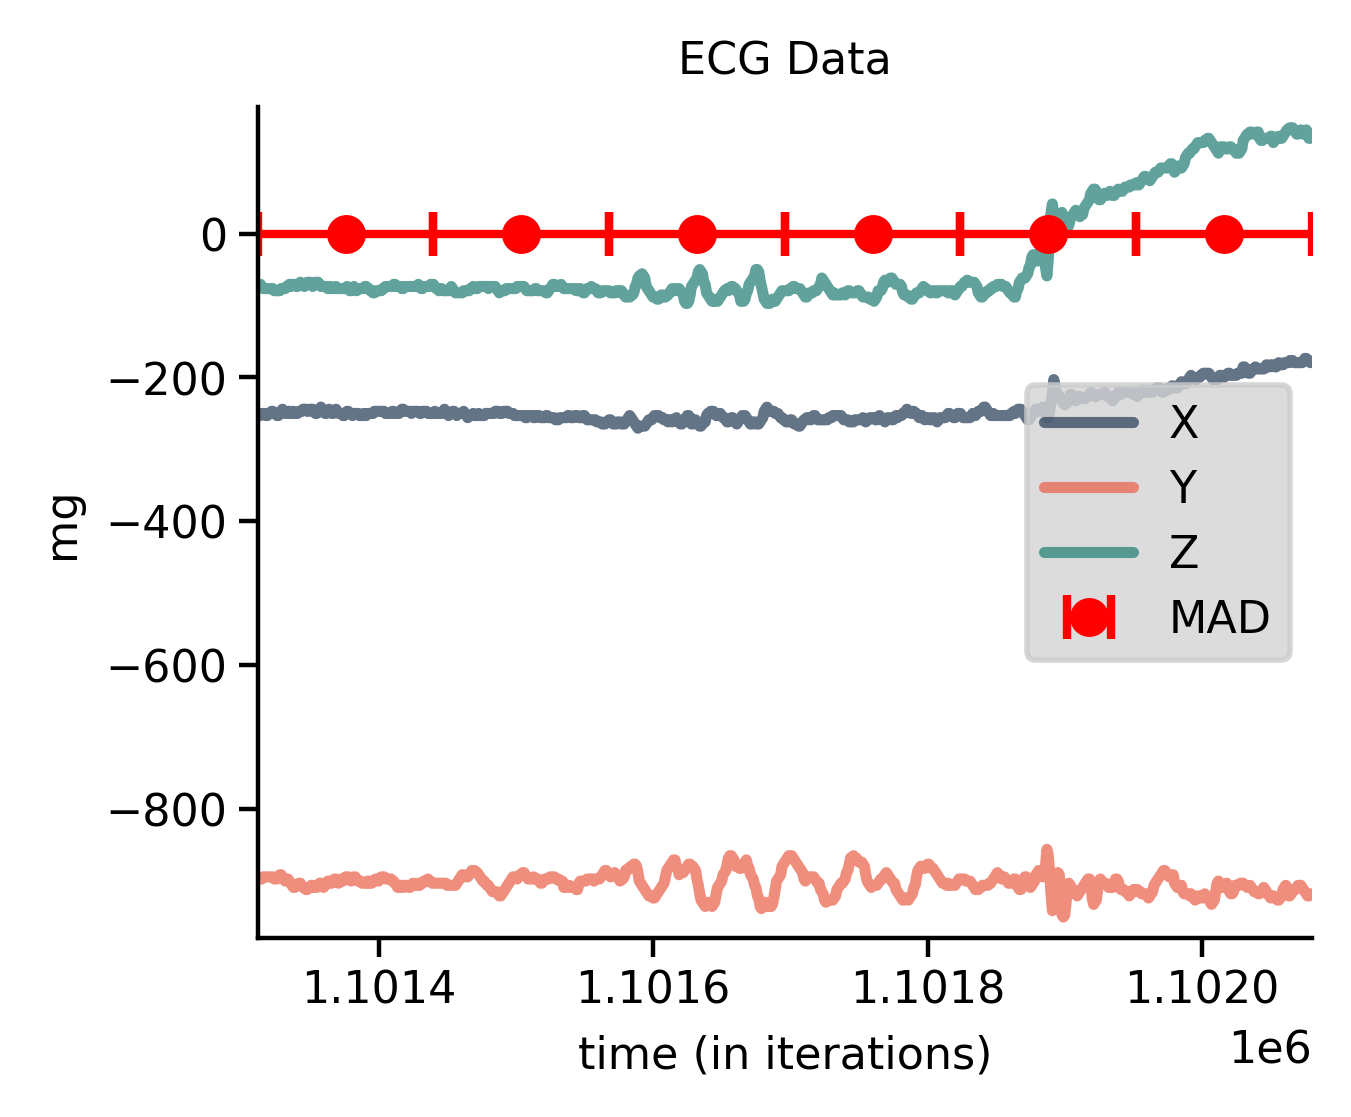

In [19]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 768 # 6 seconds for 128 Hz

# create lists to save the acceleration data and frequencies for each axis
acceleration_data = []
acceleration_data_frequencies = []

# get the acceleration data and frequency for each axis
for possible_axis_keys in parameters["wrist_acceleration_keys"]:
    this_axis_signal, this_axis_frequency = read_edf.get_data_from_edf_channel(
        file_path = file_data_path,
        possible_channel_labels = possible_axis_keys,
        physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

    # append data to corresponding lists
    acceleration_data.append(this_axis_signal)
    acceleration_data_frequencies.append(this_axis_frequency)

# load data and choose random valid interval
total_length = len(acceleration_data[0])
frequency = acceleration_data_frequencies[0]

# calculate MAD values
this_files_MAD_values = MAD.calc_mad(
        acceleration_data_lists = acceleration_data,
        frequencies = acceleration_data_frequencies, 
        time_period = 1,
    )

# choose random region to plot
random_valid_region_start = random.randint(0, total_length - interval_size)
random_valid_region_start = 1101312
x_lim = [random_valid_region_start, random_valid_region_start + interval_size]

plot_helper.plot_MAD_values(
    acceleration_data = acceleration_data,
    frequency = frequency,
    MAD_values = this_files_MAD_values, # type: ignore
    mad_time_period_seconds = parameters["mad_time_period_seconds"], 
    xlim = x_lim
    )